# Californa Houses Prices Project

In [296]:
#imports
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np



In [227]:
from pathlib import Path
import tarfile
import urllib.request
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))
housing = load_housing_data()

In [228]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [229]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [230]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


<Figure size 640x480 with 0 Axes>

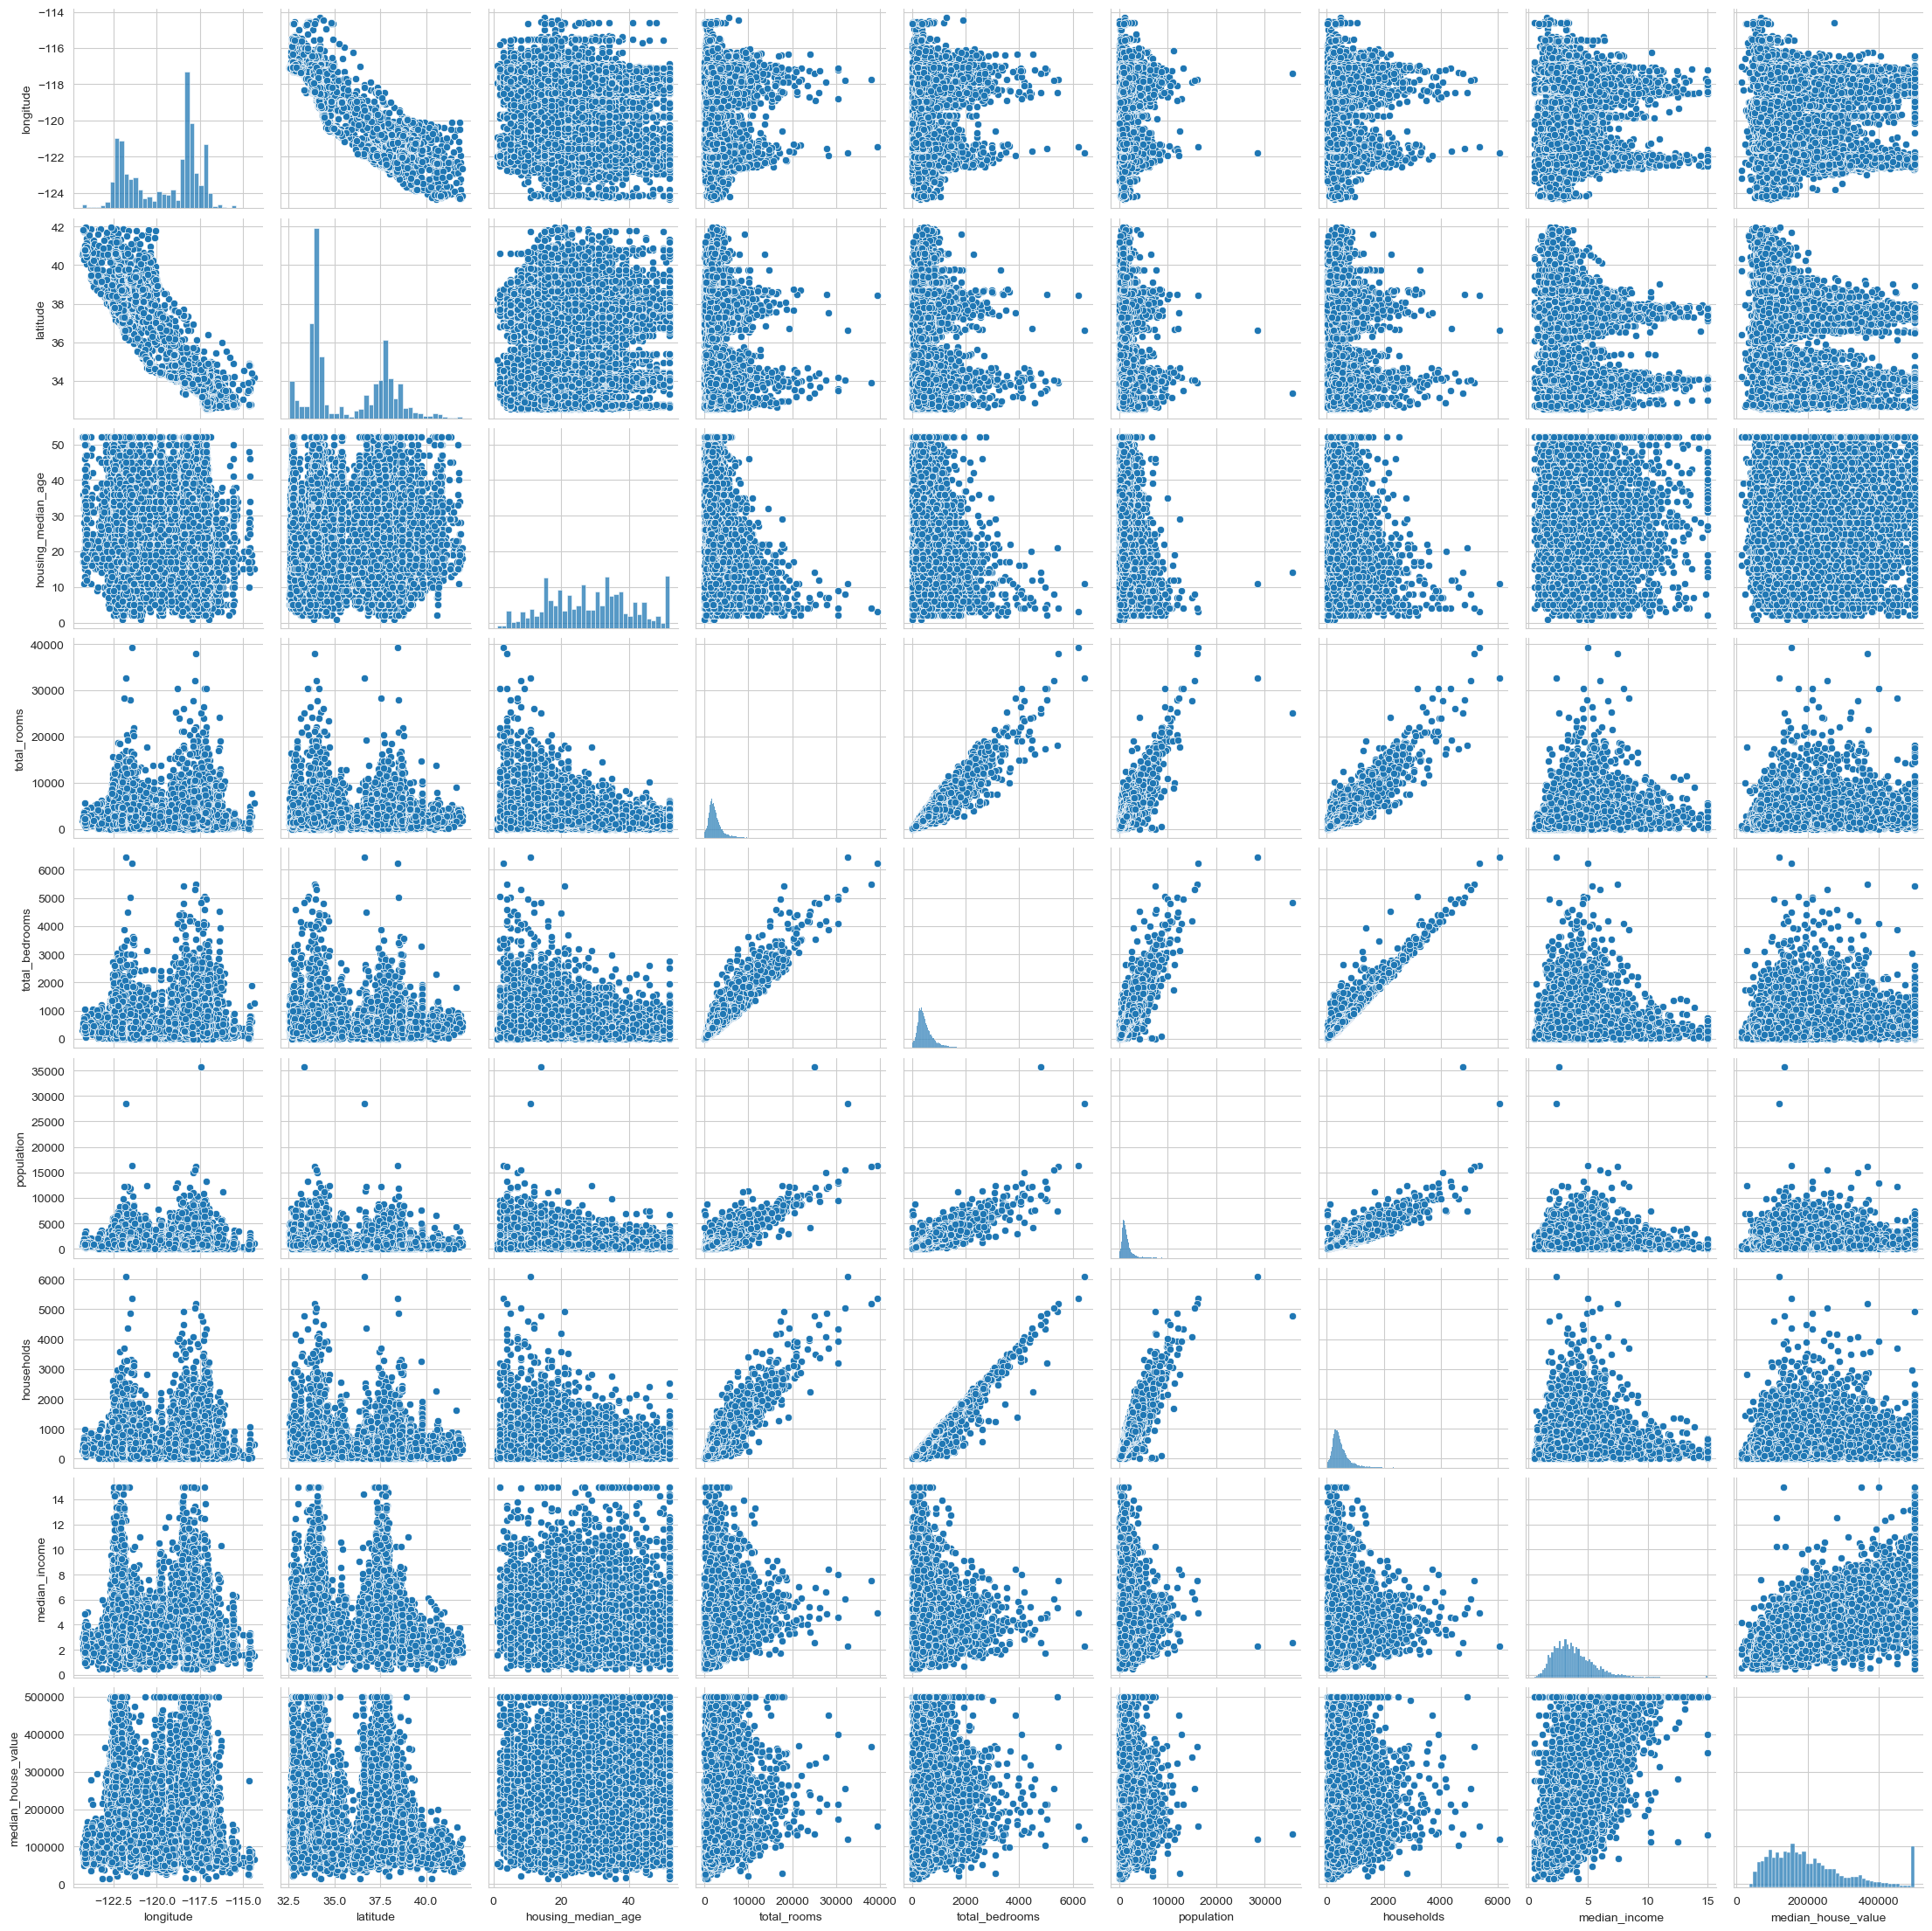

In [231]:
sns.set_style('whitegrid')
plt.tight_layout()
sns.pairplot(housing);



In [232]:
housing_num=housing.select_dtypes(include=np.number)
#This is how we can select only one type of data.

<Axes: >

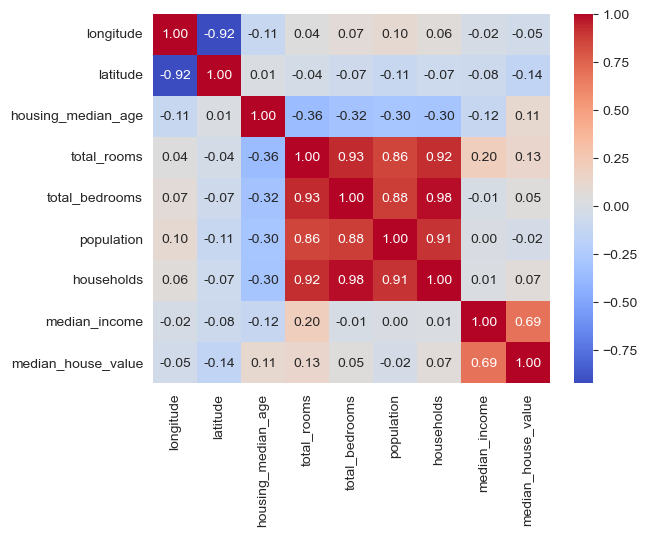

In [233]:
correlation_matrix=housing_num.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')

We can see here that the parameter median_income has strong correlation with the target variable (median_house_value).

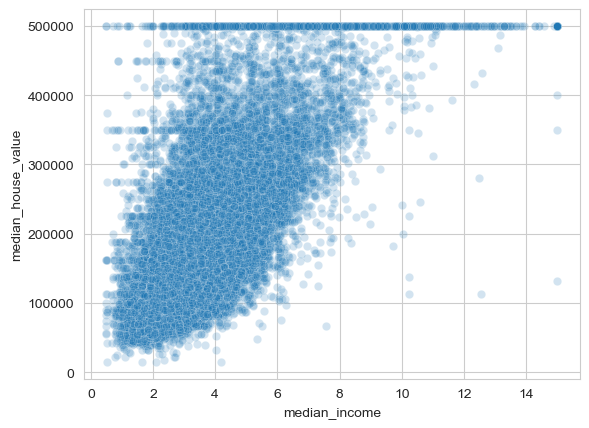

In [234]:
sns.scatterplot(data=housing,x='median_income',y='median_house_value',alpha=0.2);

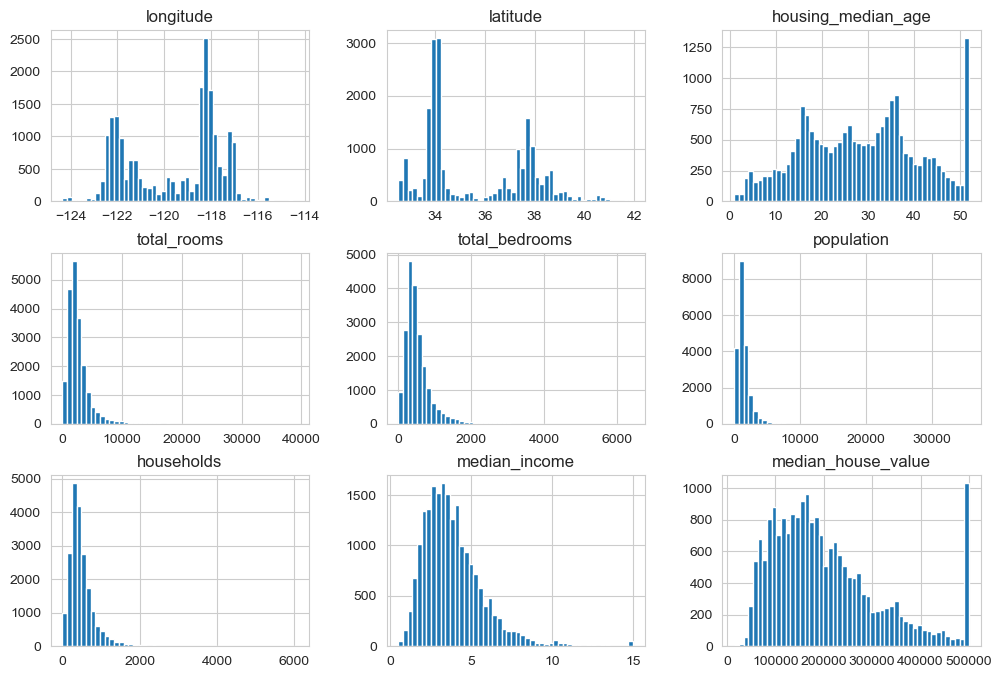

In [235]:
housing.hist(bins=50, figsize=(12,8));

In [236]:
housing['income_cat']= pd.cut(housing['median_income'], bins=[0.,1.5,3.,4.5,6.,np.inf],labels=[1,2,3,4,5])

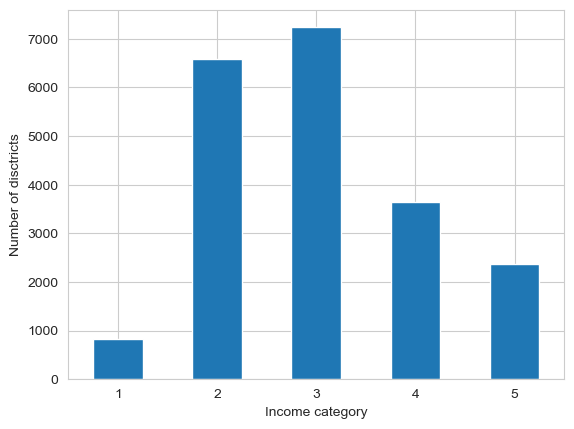

In [237]:
housing['income_cat'].value_counts().sort_index().plot.bar(rot=0);
plt.xlabel('Income category');
plt.ylabel('Number of disctricts');

In [238]:
from sklearn.model_selection import train_test_split

train_set, test_set=train_test_split(housing, test_size=0.2,)

#We must care about this, we can't set this splitting randomly. We must ensure that our training data represents the poblation correctly. In the next section we use better alternative. Let's see which are the proportions of different groups of the median_income predictor (the one with most correlation with the target)

Now we can clearly see that the distribution of median income. Lets use StratifiedShuffleSplit and compare the results with the original train_test_split.

In [239]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing['income_cat'],random_state=42)


In [240]:
strat_dist=(strat_train_set['income_cat'].value_counts()/len(strat_train_set)).sort_index()
strat_dist

income_cat
1    0.039789
2    0.318859
3    0.350594
4    0.176296
5    0.114462
Name: count, dtype: float64

Lets create a comparassion table.

In [241]:
original_dist=(housing['income_cat'].value_counts()/len(housing)).sort_index()
original_dist

income_cat
1    0.039826
2    0.318847
3    0.350581
4    0.176308
5    0.114438
Name: count, dtype: float64

In [242]:
rand_dist=(train_set['income_cat'].value_counts()/len(train_set)).sort_index()
rand_dist

income_cat
1    0.039850
2    0.315891
3    0.349564
4    0.178355
5    0.116340
Name: count, dtype: float64

In [243]:
from sklearn.metrics import root_mean_squared_error as rmse

rmse_strat_error=rmse(strat_dist,original_dist)
rmse_rand_error=rmse(rand_dist,original_dist)

In [244]:
strat_error=abs(strat_dist-original_dist)/original_dist
rand_error=abs(rand_dist-original_dist)/original_dist

In [245]:
results_dist_dict={
    'Overall %': original_dist*100,
    'Stratified %': strat_dist*100,
    'Random %': rand_dist*100,
    'Strat. Error %': strat_error*100,
    'Rand. Error %': rand_error*100
}

results_dist_df=pd.DataFrame(results_dist_dict)

print(results_dist_df)

            Overall %  Stratified %   Random %  Strat. Error %  Rand. Error %
income_cat                                                                   
1            3.982558      3.978924   3.984981        0.091241       0.060827
2           31.884690     31.885901  31.589147        0.003799       0.926911
3           35.058140     35.059351  34.956395        0.003455       0.290216
4           17.630814     17.629603  17.835514        0.006870       1.161033
5           11.443798     11.446221  11.633963        0.021169       1.661727


The results are lower than expected in the random case; this result is due to the power of statistics and the size of the dataset.

Since we no longer need the column income cat, we'll drop it.

In [246]:
strat_train_set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,458300.0,NEAR BAY,2
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,483800.0,<1H OCEAN,5
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,101700.0,INLAND,2
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,96100.0,INLAND,2
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,361800.0,NEAR OCEAN,3
...,...,...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,500001.0,<1H OCEAN,4
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,88800.0,INLAND,2
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,148800.0,NEAR OCEAN,3
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,500001.0,<1H OCEAN,3


In [247]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('income_cat',axis=1,inplace=True)

Now we start exploring the data deeper. An important notation is that we won't use the test set until the moment we want to evaluate our model.

In [248]:
housing=strat_train_set.copy() #We make a copy to do modifications

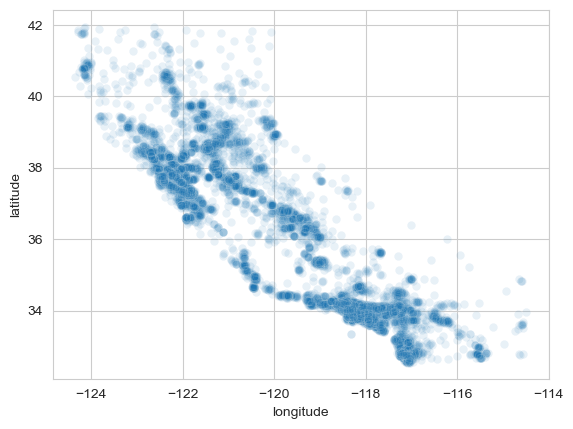

In [249]:
sns.scatterplot(data=housing, x='longitude', y='latitude',alpha=0.1);

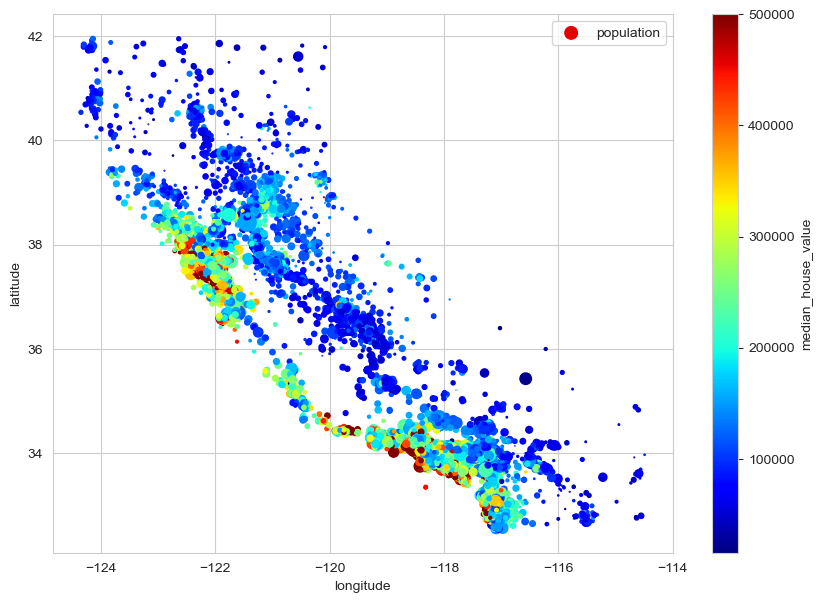

In [250]:
housing.plot(kind='scatter', x='longitude', y='latitude',
                s=housing['population']/100 ,label='population',#We declare the column because we want to do an operation with it.
                c='median_house_value',cmap='jet',colorbar=True,
                legend=True,figsize=(10,7));

In [251]:
corr_matrix=housing.select_dtypes(np.number).corr()
corr_matrix['median_house_value'].sort_values(ascending=False) 

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

Since median_income is the one with most correlation to the target and the next attributes are not so much correlated, let's try to do attribute combination in order to achieve stronger relations.

In [252]:
housing['rooms_per_house']=housing['total_rooms']/housing['households']
housing['bedrooms_ratio']=housing['total_bedrooms']/housing['total_rooms']
housing['people_per_house']=housing['population']/housing['households']
corr_matrix=housing.select_dtypes(np.number).corr()
corr_matrix['median_house_value'].sort_values(ascending=False) 

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

We can see that the bedrooms_ratio and rooms_per_house are more correlated that most of the attributes that we had before. 

The first step to prepare the data to feed a prediction model is the separation of the labels we want to predict. 

In [253]:
housing_labels=housing['median_house_value'].copy() #This is to ensure that the new dataframe is an entire new object from the original and it is not linked.
housing=housing.drop(['median_house_value','rooms_per_house','people_per_house','bedrooms_ratio'],axis=1)

In [254]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987,NEAR BAY
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876,<1H OCEAN
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330,INLAND
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618,INLAND
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292,NEAR OCEAN
...,...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105,<1H OCEAN
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733,INLAND
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616,NEAR OCEAN
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455,<1H OCEAN


Next, we will deal with the missing data. We have three oprtions:

In [255]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


In [256]:
#housing.dropna(subset=['total_bedrooms','bedrooms_ratio'], inplace=True) #Option 1: Get rid of the districts that has some NaN values

#housing.drop('total_bedrooms', axis=1) #Option 2: Get rid of the whole atribute.

The third option is to replace the missing values by the median of each feature, using a SimpleImputer instance that strores the median value of each atribute.

In [257]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

housing_num=housing.select_dtypes(include=[np.number])

imputer.fit(housing_num)

,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


Let's see what has stored

In [258]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [259]:
np.set_printoptions(suppress=True)

In [260]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [261]:
X= imputer.transform(housing_num)
X

array([[-122.42  ,   37.8   ,   52.    , ..., 1576.    , 1034.    ,
           2.0987],
       [-118.38  ,   34.14  ,   40.    , ...,  666.    ,  357.    ,
           6.0876],
       [-121.98  ,   38.36  ,   33.    , ...,  562.    ,  203.    ,
           2.433 ],
       ...,
       [-117.06  ,   32.59  ,   13.    , ..., 2814.    ,  760.    ,
           4.0616],
       [-118.4   ,   34.06  ,   37.    , ..., 1725.    ,  838.    ,
           4.1455],
       [-122.41  ,   37.66  ,   44.    , ...,  682.    ,  212.    ,
           3.2833]], shape=(16512, 8))

We have more options to replace these missing values: strategy="mean", strategy="most_frequent", strategy="constant", fill_value=… 

But there are more powerful options such as KNNImputer and IterativeImputer

Let's create a df with the filled values:

In [262]:
housing_tr=pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

Now, we are going to handle categorical attributes;

In [263]:
housing_cat=housing[['ocean_proximity']]
housing_cat.value_counts()

ocean_proximity
<1H OCEAN          7274
INLAND             5301
NEAR OCEAN         2089
NEAR BAY           1846
ISLAND                2
Name: count, dtype: int64

In [264]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder= OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [265]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [266]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [267]:
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [268]:
df_output= pd.DataFrame(housing_cat_1hot.toarray(),
                        columns=cat_encoder.get_feature_names_out(),
                        index=housing_cat.index)

df_output.head()

,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
13096,0.0,0.0,0.0,1.0,0.0
14973,1.0,0.0,0.0,0.0,0.0
3785,0.0,1.0,0.0,0.0,0.0
14689,0.0,1.0,0.0,0.0,0.0
20507,0.0,0.0,0.0,0.0,1.0


After having handled with missing values and categorical data, our goal is to scale and transform it in order to obtain better results from the model.

In [269]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler=MinMaxScaler(feature_range=(-1,1)) #neural networks work best with zero-mean inputs, so a range of –1 to 1 is preferable
housing_num_min_max_scaled= min_max_scaler.fit_transform(housing_num)

In [270]:
from sklearn.preprocessing import StandardScaler

std_scaler=StandardScaler()
housing_num_std_scaled= std_scaler.fit_transform(housing_num)

Dealing with heavy tails: We can use square root or log to make the distributions closer to a Gaussian one.

In [271]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


<Figure size 640x480 with 0 Axes>

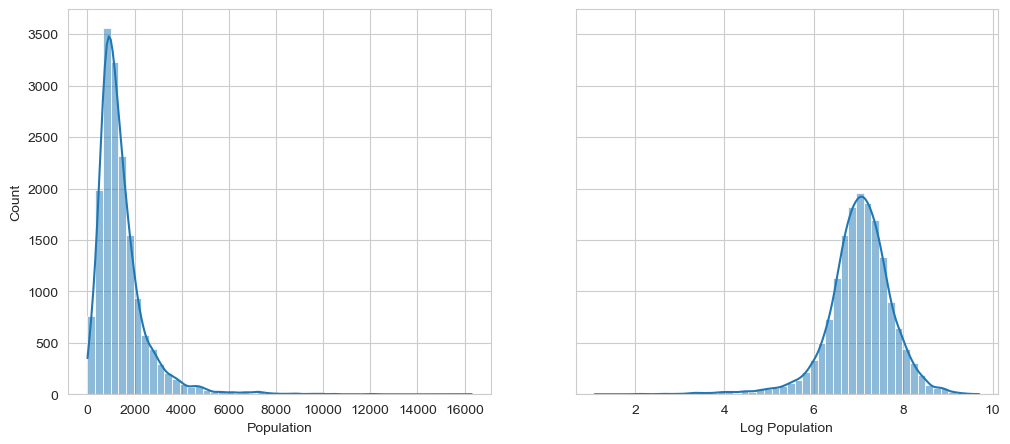

In [272]:
plt.tight_layout();
fig, axes = plt.subplots(1,2, figsize=(12,5), sharey=True);

sns.histplot(data=housing , x='population', bins=50, ax=axes[0],kde=True);
axes[0].set_xlabel('Population');

log_population=np.log(housing['population']);
axes[1].set_xlabel('Log Population');

sns.histplot(log_population, bins=50, ax=axes[1],kde=True);

What if we have a multimodal distribution? Let's explore the column housing_median_age:

<Axes: xlabel='housing_median_age', ylabel='Count'>

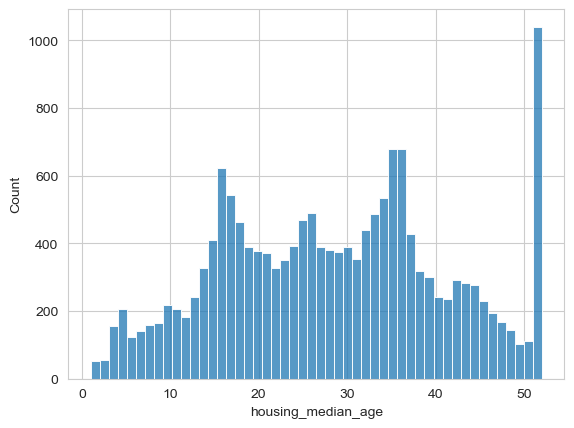

In [273]:
sns.histplot(housing['housing_median_age'],bins=50)

To handle this kind of situation we'll use a strategy called bucketizing. It consists in creating new features that compute how far (similar) is a point from the mode center. That way the model will be able to capture patterns realted to each peak. Will use the radial basis function (RBF) to compute this similarity.

In [274]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35=rbf_kernel(housing[['housing_median_age']],[[35]],gamma=0.1)
age_simil_16=rbf_kernel(housing[['housing_median_age']],[[16]],gamma=0.1)

Let's explore now how can we use custom transformers to do prepare the data.

In [275]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop=log_transformer.transform(housing['population'])

In [276]:
rbf_transformer= FunctionTransformer(rbf_kernel, kw_args= dict(Y=[[35.]], gamma=0.1))

age_simil_35=rbf_transformer.transform(housing[['housing_median_age']])

#The same that we did before.

In [277]:
#Distance to San francisco
sf_coords = 37.7749, -122.41
sf_transformer=FunctionTransformer(rbf_kernel,kw_args= dict(Y=[sf_coords],gamma=0.1))

sf_simil=sf_transformer.transform(housing[['latitude','longitude']])

Another power tool are the transformation pipelines. These pipelines are a secuence of estimators (that should be transformers) that end with a predictor, a transformer of any other type of estimator.

In [278]:
from sklearn.pipeline import make_pipeline

num_pipeline=make_pipeline(SimpleImputer(strategy='median'),StandardScaler())

In [279]:
housing_num

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-122.42,37.80,52.0,3321.0,1115.0,1576.0,1034.0,2.0987
14973,-118.38,34.14,40.0,1965.0,354.0,666.0,357.0,6.0876
3785,-121.98,38.36,33.0,1083.0,217.0,562.0,203.0,2.4330
14689,-117.11,33.75,17.0,4174.0,851.0,1845.0,780.0,2.2618
20507,-118.15,33.77,36.0,4366.0,1211.0,1912.0,1172.0,3.5292
...,...,...,...,...,...,...,...,...
14207,-118.40,33.86,41.0,2237.0,597.0,938.0,523.0,4.7105
13105,-119.31,36.32,23.0,2945.0,592.0,1419.0,532.0,2.5733
19301,-117.06,32.59,13.0,3920.0,775.0,2814.0,760.0,4.0616
19121,-118.40,34.06,37.0,3781.0,873.0,1725.0,838.0,4.1455


In [280]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)
housing_num_prepared[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17]])

In [281]:
df_housing_num_prepared= pd.DataFrame(housing_num_prepared, columns=num_pipeline.get_feature_names_out(),index=housing_num.index)
df_housing_num_prepared


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365
...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396


In [292]:
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state =random_state
        
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)
    
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

#This applies KMeans and then makes a rbf for each cluster

This method work so well. But what if we made a pipeline capable of dealing with both numerical and categorical data?

In [282]:
from sklearn.compose import ColumnTransformer

num_attribs = housing.select_dtypes(np.number).columns
cat_attribs = housing.select_dtypes(include=['object']).columns

cat_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

preprocessing = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

In [283]:
from sklearn.compose import make_column_selector, make_column_transformer

cat_pipeline=make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore'))

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

#A cleaner version

In [284]:
housing_prepared = preprocessing.fit_transform(housing)

Let's complete our pipeline with all the feature engineering that we did before:

In [293]:


def column_ratio(X):
    return X[:,[0]]/X[:,[1]]

def ratio_name (funcion_transformer, features_names_in):
    return ['ratio'] #features names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy='median'),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log, feature_names_out='one-to-one'),
    StandardScaler())

cluster_simil=ClusterSimilarity(n_clusters=10, gamma=1.,random_state=42)
default_num_pipeline= make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

preprocessing = ColumnTransformer([
    ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
    ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
    ("people_per_house", ratio_pipeline(), ["population", "households"]),
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                            "households", "median_income"]),
    ("geo", cluster_simil, ["latitude", "longitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
],
remainder=default_num_pipeline) # one column remaining: housing_median_age

In [294]:
housing_prepared = preprocessing.fit_transform(housing)

c:\Users\Gambo\anaconda3\envs\ml_env\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [299]:
df_housing_prepared= pd.DataFrame(housing_prepared,
                                  columns=preprocessing.get_feature_names_out(),
                                  index=housing.index)
df_housing_prepared

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,geo__Cluster 0 similarity,geo__Cluster 1 similarity,...,geo__Cluster 6 similarity,geo__Cluster 7 similarity,geo__Cluster 8 similarity,geo__Cluster 9 similarity,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__housing_median_age
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,4.581829e-01,1.241847e-14,...,8.489216e-04,9.770322e-01,2.382191e-08,3.819126e-18,0.0,0.0,0.0,1.0,0.0,1.861119
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,6.511495e-10,9.579596e-01,...,5.614049e-27,1.260964e-13,1.103491e-01,3.547610e-01,1.0,0.0,0.0,0.0,0.0,0.907630
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,3.432506e-01,4.261141e-15,...,5.641131e-03,7.303265e-01,2.508224e-08,2.669659e-18,0.0,1.0,0.0,0.0,0.0,0.351428
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,2.244844e-15,2.704823e-01,...,5.913326e-35,5.201263e-20,1.712982e-03,8.874598e-01,0.0,1.0,0.0,0.0,0.0,-0.919891
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,1.090228e-11,9.422206e-01,...,5.421817e-30,1.048030e-15,2.568824e-02,5.279506e-01,0.0,0.0,0.0,0.0,1.0,0.589800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.804368,-0.452111,-0.269780,0.465581,0.109720,-0.247054,0.379471,0.648953,1.115293e-10,9.505920e-01,...,1.878046e-28,1.651285e-14,4.776856e-02,3.463930e-01,1.0,0.0,0.0,0.0,0.0,0.987087
13105,-0.192328,0.036792,-0.073741,0.454022,0.477277,0.314542,0.402773,-0.637675,1.409886e-03,1.430917e-03,...,7.663746e-14,9.538119e-06,4.530237e-01,9.507766e-05,0.0,1.0,0.0,0.0,0.0,-0.443146
19301,-0.242492,-0.109987,0.158542,0.824206,0.859552,1.243381,0.889897,0.333540,8.098794e-20,3.501819e-02,...,1.715187e-42,5.158970e-25,5.966953e-06,1.346576e-01,0.0,0.0,0.0,0.0,1.0,-1.237721
19121,0.259775,-0.360937,-0.210332,0.987851,0.811293,0.579462,1.023329,0.377051,4.385614e-10,9.667073e-01,...,2.464809e-27,8.018690e-14,8.956217e-02,3.478114e-01,1.0,0.0,0.0,0.0,0.0,0.669257
